<center><h1>Logistic Regression - 2</h1></center>

**<center>Aditya Vallabh</center>**
**<center>IIT2016517</center>**

<h3>Question</h3>

- Using the data set of two quality test results of a microchip product, design a predictor using logistic regression which will predict the acceptance or rejection of the microchip given the two test results.
- Use regularizer to further tune the parameters.
- Use 70 % data for training and rest 30% data for testing your predictor and calculate the efficiency of the predictor/hypothesis.

**Requirements:**
- numpy
- pandas
- matplotlib

In [444]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from math import exp, log
%matplotlib inline

Define cost functions and helper function to perform `sigmoid` and `logarithm` on numpy arrays

In [445]:
def sigmoid(x):
  return 1 / (1 + exp(-x))
sigmoid_v = np.vectorize(sigmoid)

def logarithm(x):
  return log(x)
log_v = np.vectorize(logarithm)

def err(yy, y):
    diff = yy - y
    return -1/(len(y))*sum(y*log_v(yy) + (1-y)*log_v(1-yy))

count_wrong = lambda test_y,yy: sum([a != b for a,b in zip(test_y, yy)])

<h3>Gradient Descent Method</h3>

Performs gradient descent by using the above cost function and returns the final `weights` along with a `costs` array

In [446]:
def gradient_descent(x, y, epochs, learning_rate, w=None, L=0):
    errs = []
    X = np.ones((x.shape[0],x.shape[1]+1))
    X[:,1:] = x
    if not w:
        w = np.zeros(X.shape[1])
    N = float(len(y))
    for i in range(epochs):
        y_lin = (X.dot(w))
        y_current = sigmoid_v(y_lin)
        errs.append(err(y_current, y))
        diff = y_current - y
        Z = (X.T.dot(diff))
        w_gradient = (1/N) * Z
        regularization = (L/N)*w
        regularization[0] = 0
        w -= (learning_rate * (w_gradient + regularization))
    return w, errs

Predict the price given weights and features

In [447]:
def predict(x, W):
    X = np.ones((x.shape[0],x.shape[1]+1))
    X[:,1:] = x
    pred = []
    for t in X:
        pred.append(t.dot(W))
    return [int(round(n)) for n in sigmoid_v(np.array(pred))]

Plot the data points along with decision boundary if `weights` are given

In [448]:
def plotData(data, label_x, label_y, label_pos, label_neg, W=np.array([]), x=None, axes=None):
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    if axes == None:
        plt.figure(0)
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True)
    if W.any():
        a, b, c, d, e, f = W
        disc = ((c + f*x)**2) - 4*e*(d*x*x + b*x + a)
        disc = disc * (disc > 0)
        y = (-(c + f*x) + np.sqrt(disc))/(2*e)
        plt.plot(x,y, '-r')
        y = (-(c + f*x) - np.sqrt(disc))/(2*e)
        plt.plot(x,y, '-r')
    plt.show()

- Read the dataset and split it into 70-30 ratio
- Visualize the data points 

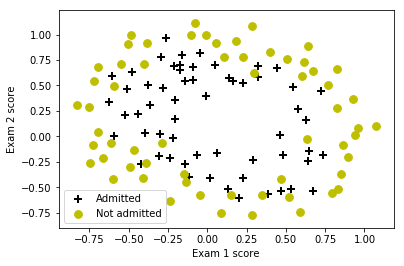

In [449]:
df = pd.read_csv('chip.csv')
df = df.sample(frac=1)
df = df.reset_index(drop=True)
split = .7
idx = int(split*len(df))
train_x, train_y = df.loc[:idx,:'two'].values, df.loc[:idx,'result'].values
test_x, test_y   = df.loc[idx:,:'two'].values, df.loc[idx:,'result'].values
plotData(df.iloc[:,0:].values, 'Test 1', 'Test 2', 'Accepted', 'Rejected')

The datapoints cannot be separated by a single line. Hence we require higher powers of the input parameters.

The following block transforms the input features from `[X Y]` to `[X Y X^2 Y^2 X*Y]`

In [450]:
X = np.zeros((train_x.shape[0], train_x.shape[1]+3))
X[:,:2] = train_x
X[:,2:4] = np.square(train_x)
X[:,4] = np.multiply(train_x[:,0], train_x[:,1])
train_x = X

X = np.zeros((test_x.shape[0], test_x.shape[1]+3))
X[:,:2] = test_x
X[:,2:4] = np.square(test_x)
X[:,4] = np.multiply(test_x[:,0], test_x[:,1])
test_x = X

Perform gradient descent for 100000 epochs and 2e-3 learning rate

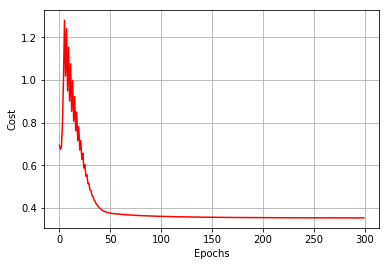

Weights: [  4.51525839   2.90746749   3.76459702 -10.11058081 -10.0139676
  -5.45856784]
Cost: 0.3527125764429775


In [451]:
W2, errs = gradient_descent(train_x, train_y, epochs=300, learning_rate=1e1, L=.01)
plt.plot(range(len(errs)), errs, '-r')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()
print('Weights: {}'.format(W2))
print('Cost: {}'.format(errs[-1]))

In [452]:
yy = predict(test_x, W2)
num_errs = count_wrong(yy, test_y)
print('{}/{} errors => {:.02f}% accuracy'.format(num_errs, len(yy), 100.0*(1-num_errs/len(yy))))

7/36 errors => 80.56% accuracy


Draw the decision boundary

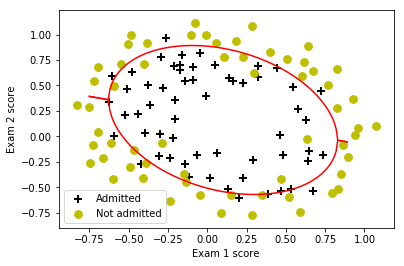

In [453]:
x = np.arange(-.75,.9,0.01)
# x = np.arange(43,100,1)
plotData(df.iloc[:,0:].values, 'Test 1', 'Test 2', 'Accepted', 'Rejected', W2, x)

*The decision boundary neatly separates the data points into distinct classes*

Given training and testing data, vary **lambda** (regularization parameter) and return the corresponding costs for every lambda

In the function below, we vary lambda from 1 to 1e-5

In [454]:
def analyze(x_train, y_train, x_test, y_test):
    G_r = []
    L_r = []

    for L in range(0, 5, 1):
        L = .1**L
        L_r.append(L)
        W2, errs = gradient_descent(train_x, train_y, epochs=300, learning_rate=1e1, L=L)
        yy = predict(x_test, W2)
        grad_err = count_wrong(yy, y_test)
    #     print('Gradient Descent Error: {}'.format(grad_err))
        G_r.append(grad_err)
    #     print(W2)
    return L_r, G_r

Plot graphs comparing the performance of Normal Equations and Gradient Descent in `Cost vs Lambda`

In [457]:
def plot_graphs(L_r, G_r):
    # plt.plot(range(len(errs)), [norm_err]*len(errs), '-g')
    # plt.plot(range(len(errs)), errs, '-r')
    plt.plot(L_r, G_r, '-r', label='Grad desc.')
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Error')
    plt.legend()
    plt.grid()
    plt.show()

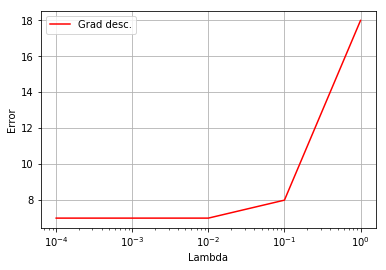

In [458]:
L_r, G_r = analyze(train_x, train_y, test_x, test_y)
plot_graphs(L_r, G_r)

<h3>Observations</h3>

We observe that:
- The decision boundary obtained neatly separates the data points into 2 distinct classes as required
- Increasing lambda has a degrading effect on the results when lambda >= 1
- For lambda = 0.01, however, we get the least error

<h3>Conclusion</h3>

- Logistic regression works way better than linear regression when there's 0-1 classification problem
- The given dataset has less features hence overfitting is negligible